In [1]:
import pandas 			 as pd
import numpy 			 as np
import matplotlib.pyplot as plt

import scipy.signal as signal

from sklearn.preprocessing 	 import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics 		 import r2_score
from sklearn.linear_model 	 import LinearRegression

import joblib


# Load dataset

ECG's metadata

In [2]:
ecgHeaders = [
	"sample",
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]


ecgFeatures = [
	"LI", 
	"aVF", 
	"V2"
]

ecgTarget = [
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"V1",
	"V3",
	"V4",
	"V5",
	"V6"
]


In [3]:
ecgPlotHeaders = [
    "LI", "aVR", "V1", "V4",
	"LII", "aVL", "V2", "V5",
	"LIII", "aVF", "V3", "V6"
]

ecgPlotColors = {
	"LI": 	"seagreen",
	"aVR": 	"black",
	"V1": 	"gold",
	"V4": 	"orangered",
	"LII": 	"cornflowerblue",
	"aVL": 	"seagreen",
	"V2": 	"gold",
	"V5": 	"crimson",
	"LIII": "cornflowerblue",
	"aVF":  "cornflowerblue",
	"V3":   "orangered",
	"V6":   "crimson"
}

ECG's labels

In [4]:
ecgsDataset = []

with open("../../../data/labels/RECORDS-acceptable") as file:
	ecgsDataset = map(
		lambda ecgName: ecgName.strip(), 
		file.readlines()
	)
	ecgsDataset = list(ecgsDataset) 

	print("Quantidade de ECG's disponíveis:", len(ecgsDataset))

Quantidade de ECG's disponíveis: 773


Split dataset

In [5]:
trainEcgs, validationEcgs = train_test_split(
	ecgsDataset, 
	train_size = .70, 
	test_size  = .30
)

print("Quantidade de ECG para treinamento:", len(trainEcgs))
print("Quantidade de ECG para validação:", len(validationEcgs))

Quantidade de ECG para treinamento: 541
Quantidade de ECG para validação: 232


# Preprocessing Dataset

- highpass butterworth filter with $ f_c = 1$ Hz
- Truncation in the tails of $N = 500 $ samples
- With 5 Gain

Making the highpass butter filter

In [6]:
order = 2
fc = 1
fs = 500

b, a = signal.butter(
	N 	  = order,
	Wn 	  = fc,
	btype = "highpass",
	fs    = fs
)

print("Numerador: ", b)
print("Denominador: ", a)

Numerador:  [ 0.9911536  -1.98230719  0.9911536 ]
Denominador:  [ 1.         -1.98222893  0.98238545]


Filtering and crop 

In [7]:
def preprocessing(ecgDf):
	ecgFiltred = ecgDf.apply(
		lambda serie: 5 * signal.filtfilt(b, a, serie), 
		axis = 0
	)
	ecgCroped = ecgFiltred.iloc[500: -500]

	return ecgCroped

In [8]:
xTrainAll = []
yTrainAll = []

for trainEcgFile in trainEcgs:
	ecgDf = pd.read_csv(
		filepath_or_buffer = f"../../../data/set-a/{trainEcgFile}.txt",
		names 			   = ecgHeaders,
		index_col 		   = 0
	)

	ecgDf = preprocessing(ecgDf)

	xTrain = ecgDf[ecgFeatures]
	yTrain = ecgDf[ecgTarget]
	
	xTrainAll.extend(xTrain.values)
	yTrainAll.extend(yTrain.values)

xTrainAll = np.array(xTrainAll)
yTrainAll = np.array(yTrainAll)


In [9]:
xValidationAll = []
yValidationAll = []

for validationEcgFile in validationEcgs:
	ecgDf = pd.read_csv(
		filepath_or_buffer = f"../../../data/set-a/{validationEcgFile}.txt",
		names 			   = ecgHeaders,
		index_col 		   = 0
	)

	ecgDf = preprocessing(ecgDf)

	xValidation = ecgDf[ecgFeatures]
	yValidation = ecgDf[ecgTarget]

	xValidationAll.extend(xValidation.values)
	yValidationAll.extend(yValidation.values)

	del ecgDf

xValidationAll = np.array(xValidationAll)
yValidationAll = np.array(yValidationAll)

Normalization

In [10]:
scaler = StandardScaler()

In [11]:
xTrainScaled      = scaler.fit_transform(xTrainAll)
xValidationScaled = scaler.transform(xValidationAll)

# Training

In [12]:
linearModel = LinearRegression()

In [13]:
linearModel.fit(xTrainScaled, yTrainAll)

LinearRegression()

In [14]:
print("Coeficientes: ")
print(np.round(linearModel.coef_, 3))
print(np.round(linearModel.intercept_, 3))

Coeficientes: 
[[ 2.90574e+02 -2.57577e+02 -1.07000e-01]
 [ 1.44065e+02 -2.57577e+02 -1.07000e-01]
 [-2.17406e+02  1.28044e+02  1.07000e-01]
 [ 2.16614e+02 -2.57364e+02 -1.57000e-01]
 [-1.40992e+02  5.44420e+01  8.63190e+01]
 [ 1.32362e+02 -1.50172e+02  1.12635e+02]
 [ 2.73037e+02 -2.29197e+02  5.81750e+01]
 [ 2.80053e+02 -2.10384e+02  1.85170e+01]
 [ 2.38809e+02 -1.70124e+02 -4.58100e+00]]
[-0.066 -0.138 -0.004 -0.101 -0.291  0.739 -0.145 -0.059  0.647]


# Validation

In [15]:
yPredicted = linearModel.predict(xValidationScaled)

r2Validation = r2_score(
	y_true 		= yValidationAll, 
	y_pred 		= yPredicted,
	multioutput = "raw_values"
)
r2Validation = np.round(r2Validation, 3)
r2Validation = r2Validation.tolist()

print("R² Labels: ", ecgTarget)
print("R² Values:", r2Validation)

R² Labels:  ['LII', 'LIII', 'aVR', 'aVL', 'V1', 'V3', 'V4', 'V5', 'V6']
R² Values: [1.0, 1.0, 1.0, 0.999, 0.038, 0.34, 0.017, 0.296, 0.058]


# Ploting

In [16]:
def plotECG(ecg, headers, colors): 
	figure, axes = plt.subplots(
		nrows = 3,
		ncols = 4,
		sharex = True,
		figsize = (16, 9)
	)

	figure.suptitle("ECG 12-Lead")
	figure.supxlabel("Sample")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		axes[idx].plot(ecg[header], color = colors[header])
		axes[idx].set_title(f"{header}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

In [17]:
def comparativeFullEcgPlot(ecgOring, ecgRec, headers):
	figure, axes = plt.subplots(
		nrows   = 3,
		ncols   = 4,
		sharex  = True,
		figsize = (16, 9)
	)

	figure.suptitle("Comparison: ECG 12-Lead")
	figure.supxlabel("Sample")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		corr = np.round(ecgOring[header].corr(ecgRec[header]), 3)
		r2   = np.round(r2_score(ecgOring[header], ecgRec[header]), 3)

		axes[idx].plot(
			ecgOring[header], 
			color = "blue", 
			alpha = 0.75)
		axes[idx].plot(
			ecgRec[header], 
			color = "red", 
			alpha=0.75
		)

		axes[idx].set_title(f"{header} CORR = {corr} R² = {r2}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

In [18]:
ecgSampleDf = pd.read_csv(
	filepath_or_buffer = f"../../../samples/1031414.txt",
	names 			   = ecgHeaders,
	index_col 		   = 0
)

In [19]:
ecgSampleDf = preprocessing(ecgSampleDf)

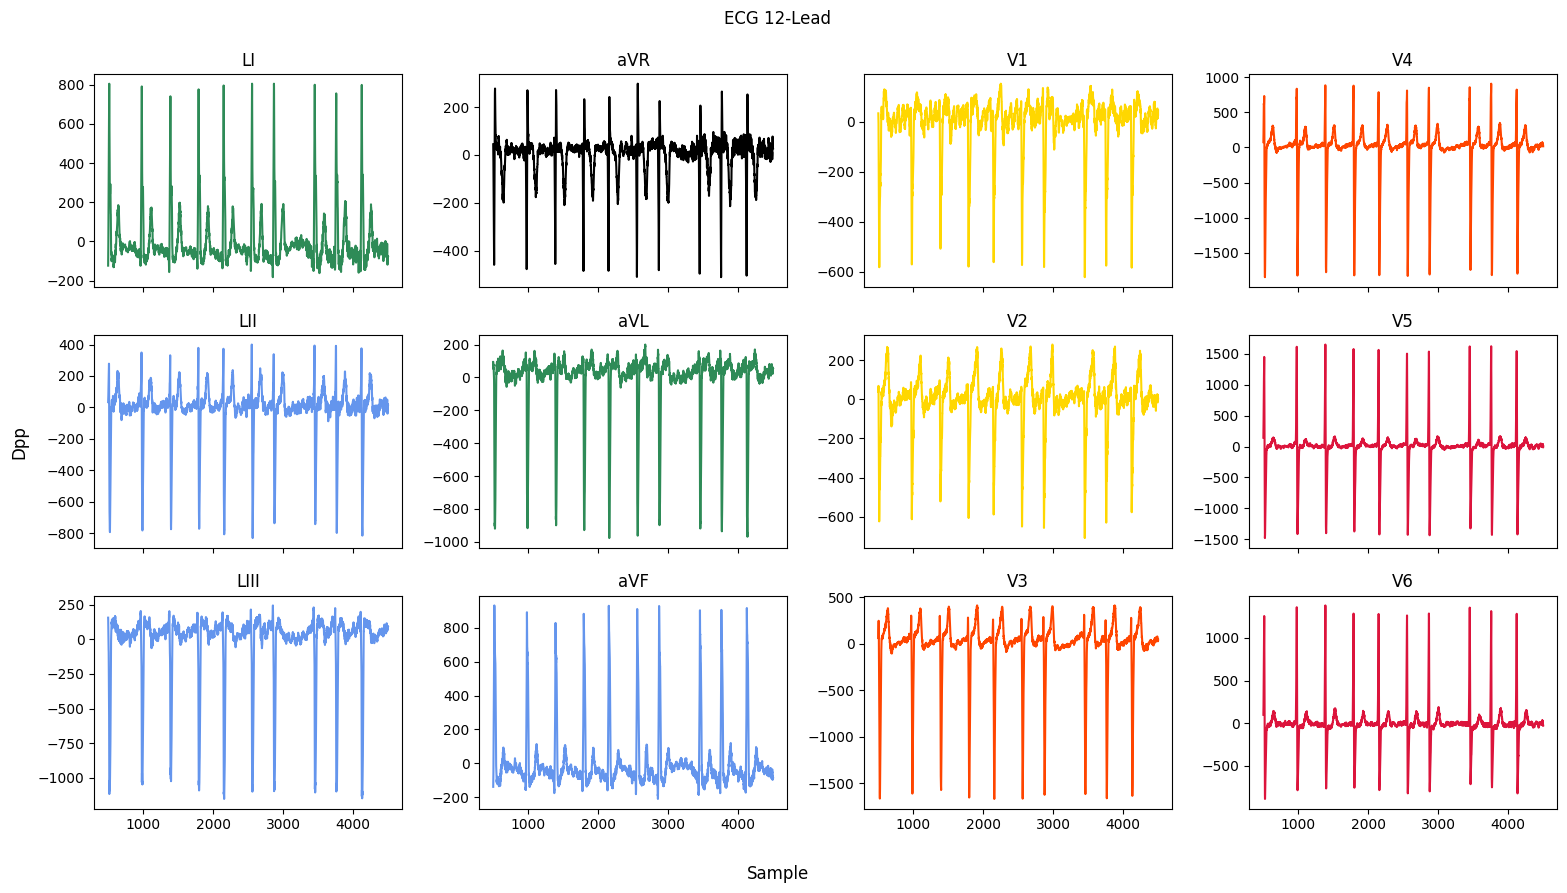

In [20]:
plotECG(
    ecg     = ecgSampleDf,  
    headers = ecgPlotHeaders, 
    colors  = ecgPlotColors
)

In [21]:
xFeaturesSampleEcgDf = ecgSampleDf[ecgFeatures]
yTargetSampleEcg = ecgSampleDf[ecgTarget].values

ecgSampleTargetPredicted = linearModel.predict(
	X = scaler.transform(
		X = xFeaturesSampleEcgDf.values
	)
)

In [22]:
ecgSampleTargetPredictedDf = pd.DataFrame(
	data    = ecgSampleTargetPredicted,
	columns = ecgTarget,
	index   = ecgSampleDf.index
)

In [23]:
ecgSampleRecDf = pd.concat([
	xFeaturesSampleEcgDf,
	ecgSampleTargetPredictedDf     
], axis = 1)


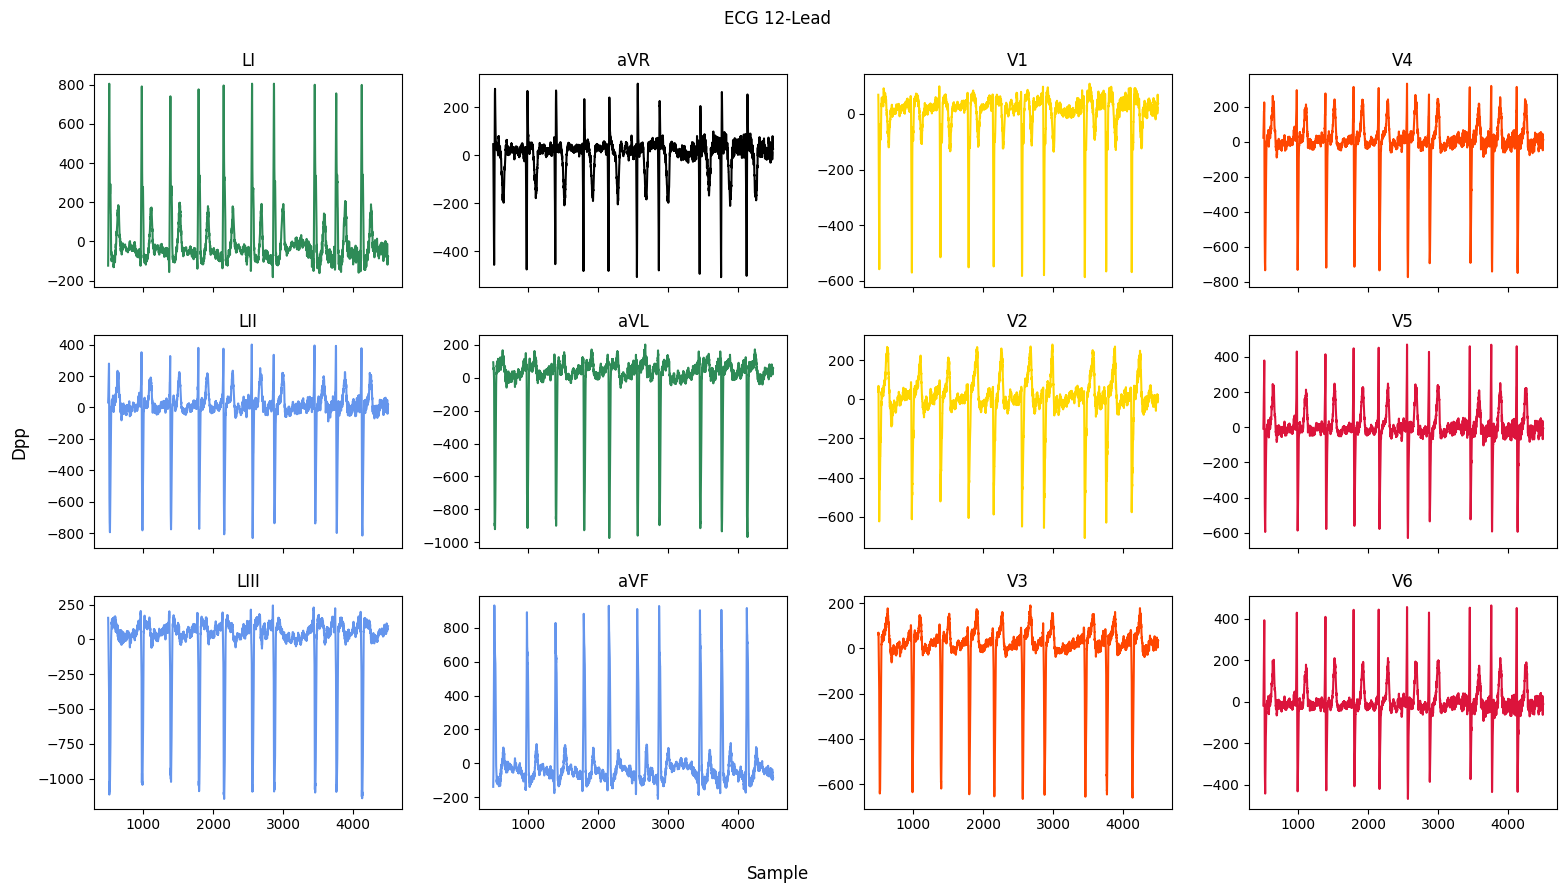

In [24]:
plotECG(
    ecg     = ecgSampleRecDf,
    headers = ecgPlotHeaders,
    colors  = ecgPlotColors
)

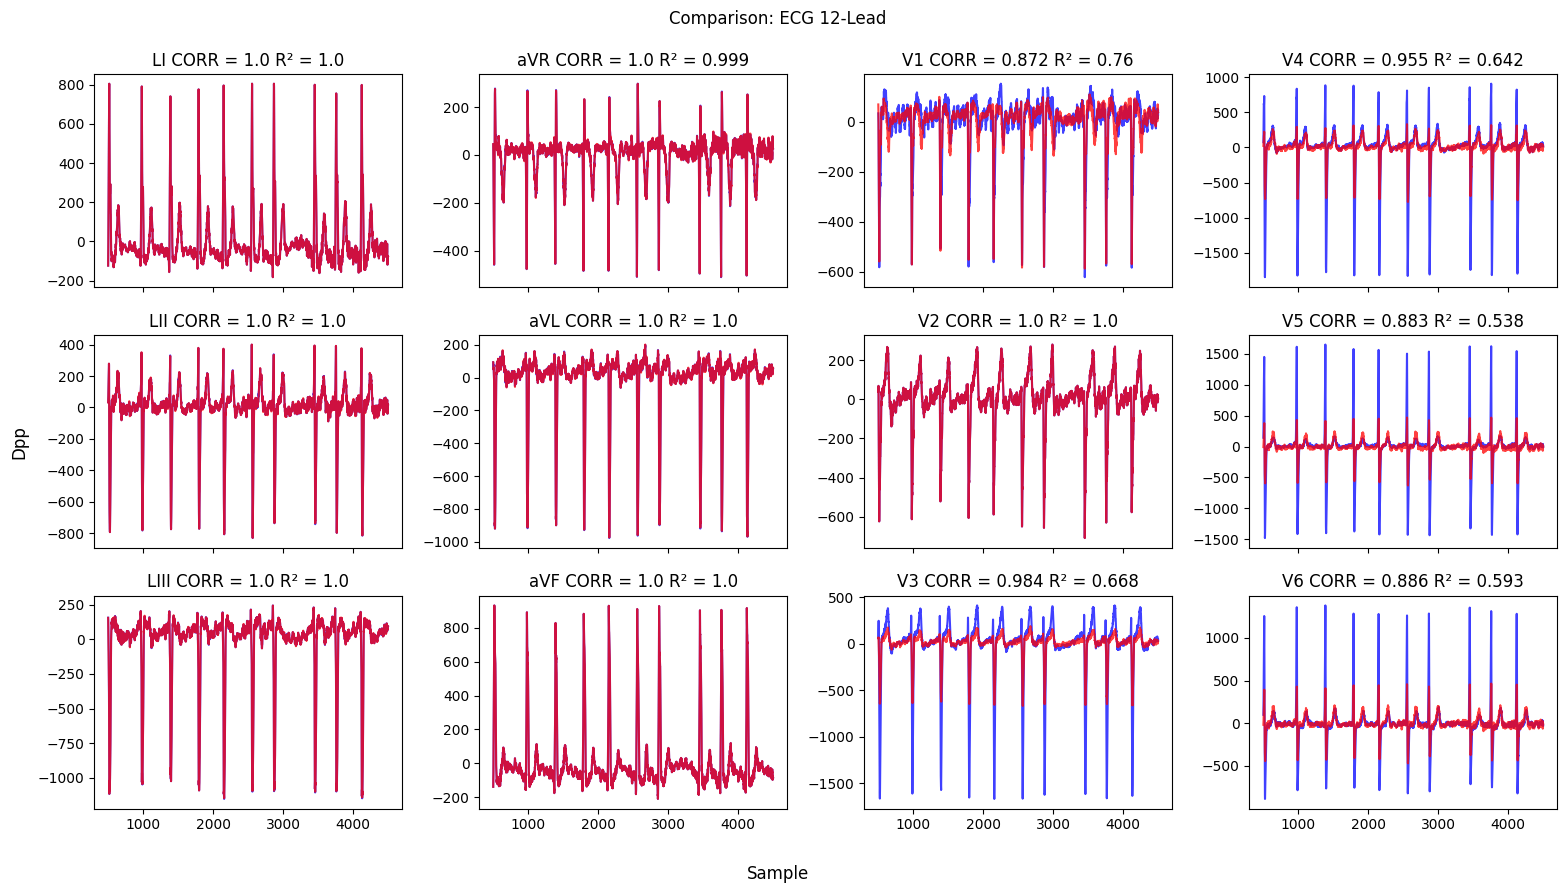

In [25]:
comparativeFullEcgPlot(
	ecgOring = ecgSampleDf,
	ecgRec   = ecgSampleRecDf,
    headers  = ecgPlotHeaders
)

In [26]:
viewport = slice(1000, 1500)

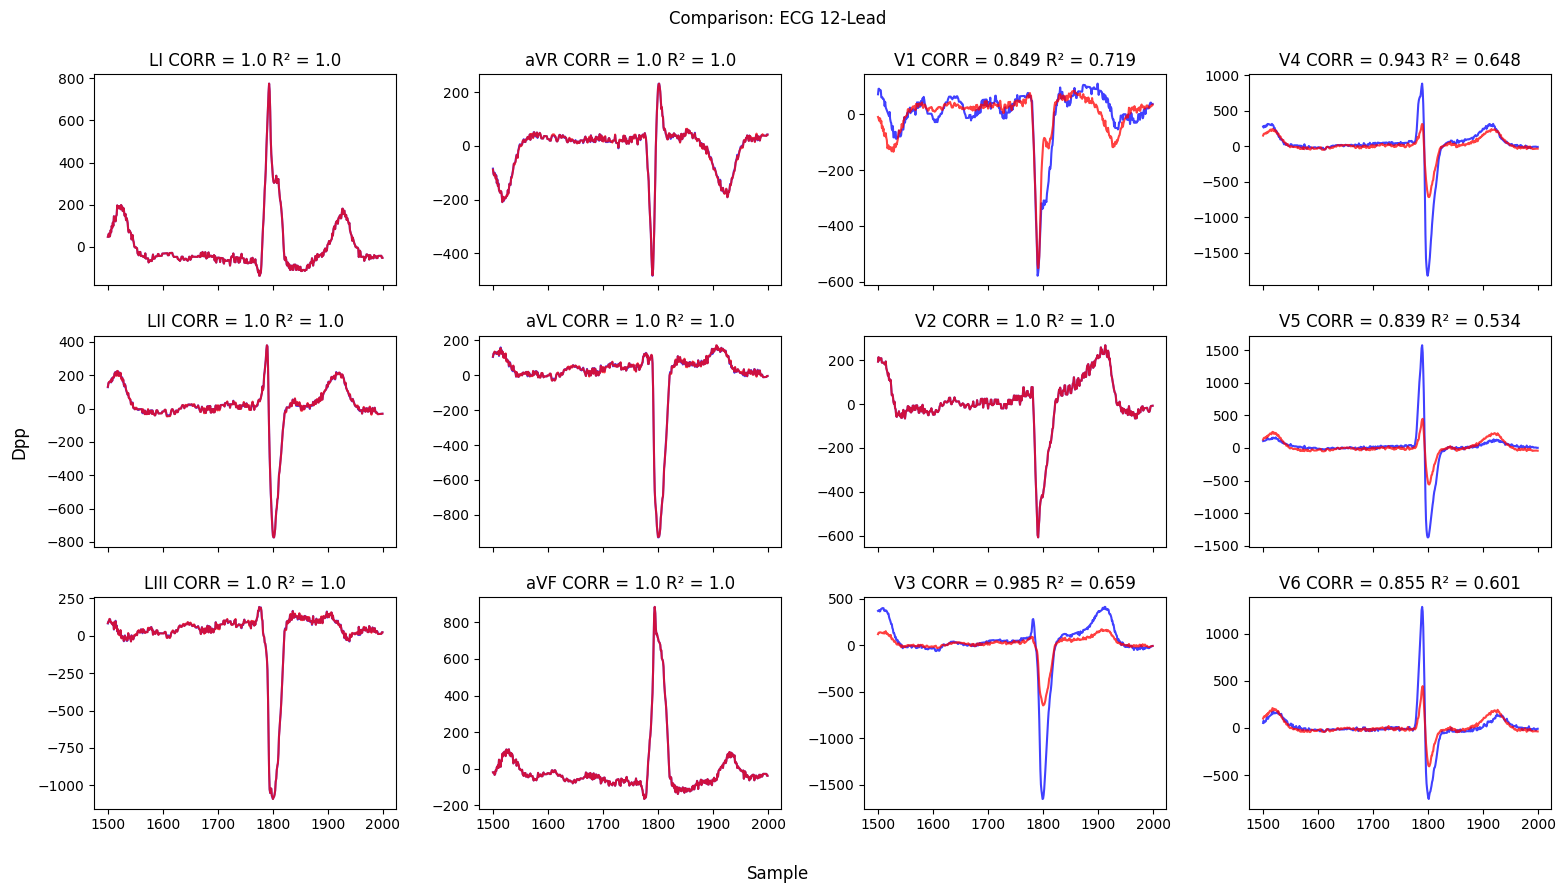

In [27]:
comparativeFullEcgPlot(
	ecgOring = ecgSampleDf[viewport],
	ecgRec   = ecgSampleRecDf[viewport],
    headers  = ecgPlotHeaders
)

# Save Model

In [28]:
joblib.dump(
	value    = linearModel,
	filename = "../../../models/t0/reglin-t0-v0.pkl"
)

joblib.dump(
	value    = scaler,
	filename = "../../../models/t0/reglin-t0-v0.scaler.pkl"
)

['../../../models/t0/reglin-t0-v0.scaler.pkl']